## VGGNet

VGGNet[1] 诞生于 2014 年，其最大的改进是在网络的深度上，相较于 AlexNet 的 8 层网络，VGGNet 则是增加到了 16 层（VGGNet16）和 19 层（VGGNet19），更深的网络意味着更强的表达能力，同时得益于其规整的网络结构，所以十分适合硬件加速。VGGNet 的另一个显著特点是仅使用了单一尺寸的 $3\times3$ 卷积核，在之前介绍卷积的感受野时也提到过，使用小卷积核堆积的效果要优于大卷积核，在减少参数的同时，提高了识别准确率。

上面提到了 VGGNet16 和 VGGNet19 两个网络，这两者只是网络的深度不同，前者 16 层（13 层卷积、3 层全连接），后者 19 层（16 层卷积、3 层全连接），本质上并没有什么区别。

VGG 提出了可以重复使用简单的基础块来构建深度模型的思路。下面就介绍一下构成 VGGNet 的基础块。

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

### VGG 块

VGG 块的组成规律是：连续使用数个相同的使用全 0 填充、核大小为 $3\times3$ 的卷积层后接上一个步幅为 2、核大小为 $2\times2$ 的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。下面实现一个 vgg_block 函数来构建基础的 VGG 块，可以指定卷积层的数量`num_covs` 和输出通道数 `num_channels`。

In [2]:
def vgg_block(num_covs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_covs):
        blk.add(Conv2D(num_channels, kernel_size=3, padding='same'))
        blk.add(BatchNormalization())
        blk.add(Activation('relu'))
    blk.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
    return blk

### VGG 网络结构

接下来利用 VGG 块构建一个 VGG网络，用来训练 Fashion MNIST 数据集，在网络结构上相比于原论文所提到的结构会有所调整。它有 5 个 VGG 块，前 2 块使用单卷积层，后 3 块使用双卷积层，一共 8 个卷积层，最后再衔接 3 个全连接层，一共 11 层网络，因此命名为 VGG11。

VGG16 也是使用了 5 个 VGG 块，只不过前 2 块使用了双卷积层，后 3 块使用了三卷积层，一共 13 层卷积层，再衔接 3 个全连接层组成 16 层网络，其他参数与接下来要实现的 VGG11 相似。因为训练的数据集不同，所以使用修改后的 VGG11，感兴趣的可以试试 VGG16 在 Fashion MNIST 上的训练效果。

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout

为了简化网络结构描述的长度，下面对于没使用到的部分就不写出来了。

+ 第 1 个 VGG 块：
  + 第 1 层：卷积层
   + C：使用 64 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
   + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，使用全 0 填充（same）
+ 第 2 个 VGG 块：
  + 第 2 层：卷积层
   + C：使用 128 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
   + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，使用全 0 填充（same）
+ 第 3 个 VGG 块：
  + 第 3 层：卷积层
   + C：使用 256 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
  + 第 4 层：卷积层
   + C：使用 256 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
   + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，使用全 0 填充（same）
+ 第 4 个 VGG 块：
  + 第 5 层：卷积层
   + C：使用 512 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
  + 第 6 层：卷积层
   + C：使用 512 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
   + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，使用全 0 填充（same）
+ 第 5 个 VGG 块：
  + 第 7 层：卷积层
   + C：使用 512 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
  + 第 8 层：卷积层
   + C：使用 512 个 $3\times3$ 的卷积核，步长为 1，使用全 0 填充（same）
   + B: 使用批标准化
   + A：使用 ReLu 激活函数
   + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，使用全 0 填充（same）
+ 全连接部分：
  + Flatten 拉伸卷积层传来的输入特征 
  + 第 9 层：全连接层
   + 4096 个神经元
   + 使用 ReLu 激活函数 
   + 使用值为 0.5 的 Dropout
  + 第 10 层：全连接层
   + 4096 个神经元
   + 使用 ReLu 激活函数 
   + 使用值为 0.5 的 Dropout
  + 第 11 层：全连接层（输出层）
   + 10 个神经元
   + 使用 softmax 激活函数


+ [1] Simonyan K , Zisserman A . Very Deep Convolutional Networks for Large-Scale Image Recognition[J]. arXiv, 2014.

实现 VGG11 的网络模型

In [3]:
vgg11 = [
    vgg_block(1, 64),
    vgg_block(1, 128),
    vgg_block(2, 256),
    vgg_block(2, 512),
    vgg_block(2, 512),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
]

训练步骤依然是之前扩展的“六步法”

In [4]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [5]:
# VGG11
model = tf.keras.models.Sequential(vgg11)

In [6]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [7]:
# 设置断点续训
checkpoint_save_path = './checkpoint/VGGNet16.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [8]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [9]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2190s 36ms/sample - loss: 0.8738 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.4779 - val_sparse_categorical_accuracy: 0.8203
Epoch 2/5
60000/60000 [==============================] - 2669s 44ms/sample - loss: 0.4928 - sparse_categorical_accuracy: 0.8169 - val_loss: 0.4517 - val_sparse_categorical_accuracy: 0.8548
Epoch 3/5
60000/60000 [==============================] - 2360s 39ms/sample - loss: 0.3865 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8712
Epoch 4/5
60000/60000 [==============================] - 2379s 40ms/sample - loss: 0.2979 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.3890 - val_sparse_categorical_accuracy: 0.8771
Epoch 5/5
60000/60000 [==============================] - 2056s 34ms/sample - loss: 0.2580 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.2623 - val_sparse_categorical_accuracy: 0.9081


In [10]:
# 打印网络结构
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  896       
_________________________________________________________________
sequential_1 (Sequential)    multiple                  74368     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  887296    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  3544064   
_________________________________________________________________
sequential_4 (Sequential)    multiple                  4723712   
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                 

In [11]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [12]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

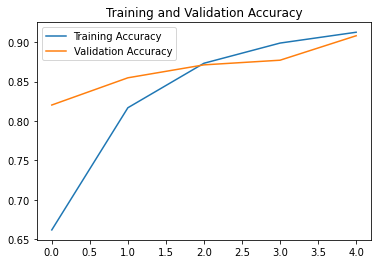

In [13]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

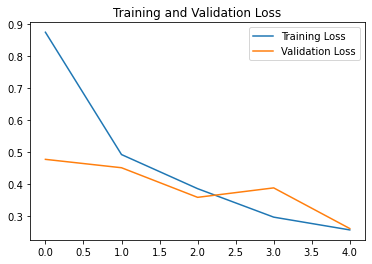

In [14]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()